# **YOLOv3**

Redmon, Joseph, and Ali Farhadi. "Yolov3: An incremental improvement." arXiv preprint arXiv:1804.02767 (2018).

https://arxiv.org/abs/1804.02767


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# **Importing**

In [4]:
import os
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle

%matplotlib inline

![alt text](https://drive.google.com/uc?id=1R3VsHcmA4BYCo-FspPFiEEqTP57qqv87)

# **Construct the network**

We first create a function for creating the Convolutional blocks

Next, we create a Darknet with 108 convolutional layers. 

In [5]:
#here we define a convolutional block, i.e. a set of subsequent convolutions
'''
inp: input activation map to the block
convs: list of convolutions of the block (each conv with its set of hyperparameters: filter, kernel, stride)
'''
def _conv_block(inp, convs, skip=True): 
    x = inp
    count = 0
    
    for conv in convs: 
        
        #short skip connection between the ouptut of the third to the last layer AND the output of the last layer
        if count == (len(convs) - 2) and skip: #if I have a block with skip connection
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet (prefer left and top padding)
        
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', #peculiar padding 
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x) # no bias in batch norm layer

        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [6]:
# creating the YOLO model
def make_yolov3_model():
  # N.B. Standard YOLOv3 input image is (416, 416)
    input_image = Input(shape=(None, None, 3))

# Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
# Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
# Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
# Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
# Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x #this will be concatenated with layer 96
        
# Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
# Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x #this will be concatenated with layer 86
        
# Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
# Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

#NO SKIP AFTER THIS POINT
# Layer 75 => 79 
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
# Layer 80 => 82 (N.B. Output is (S,S,B*(5+80)) --> (S,S,3*(5+80)) --> (13,13,255) --> Why 13?)
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
#yolo_82 will be my first output!!! #255 activation maps

# Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x) #upsampling here!
    x = concatenate([x, skip_61]) # this is the first concatenation 

# Layer 87 => 91 
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

# Layer 92 => 94 (N.B. Output is (S,S,B*(5+80)) --> (S,S,3*(5+80)) --> (26,26,255) --> Why 26?)
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    #This is my second output! #255 activation maps
# Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x) #again upsampling
    x = concatenate([x, skip_36]) #second concatenation

# Layer 99 => 106 (N.B. Output is (S,S,B*(5+80)) --> (S,S,3*(5+80)) --> (52,52,255) --> Why 52?)
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    #This is my third output! #255 activation maps

    model = Model(input_image, [yolo_82, yolo_94, yolo_106]) #here I have 3 outputs! 
    #model.summary    
    
    return model

# **Model weight parsing**

WeightReader class will parse the file and load the model weights into memory to set it in our Keras model.

In [7]:
# class to load the pretrained Weights
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model): ###
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]: #for this layers, we do not have batch norm
                    norm_layer = model.get_layer('bnorm_' + str(i)) #for layers with batch norm
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scaling
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                
                if len(conv_layer.get_weights()) > 1: #for layers with both kernel and bias
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else: #for layers without bias
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])

            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

# **Yolo model and pre-trained weights**

In [8]:
# create the yolo v3
root = "/content/gdrive/My Drive/CorsoDL/"

yolov3 = make_yolov3_model()
# load the weights trained on COCO into the model
weight_reader = WeightReader(root + "yolov3.weights")
weight_reader.load_weights(yolov3)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

# **Reading image function**

In [9]:
#Loading the image into the right input shape of 416 x 416 (shape compatible with YoloV3 training)

def load_image_pixels(filename, shape):
 # load the image to get its shape
 image = load_img(filename)
 width, height = image.size
 
# load the image with the required size
 image = load_img(filename, target_size=shape)
 # convert to numpy array
 image = img_to_array(image)
 
# scale pixel values to [0, 1]
 image = image.astype('float32')
 image /= 255.0
 
# add a dimension so that we have one sample (1,416,416,3)
 image = expand_dims(image, 0)
 return image, width, height

# **Useful Functions**

**Create a class for the Bounding Box**: BoundBox defines the corners of each bounding box in the context of the input image shape and class probabilities.

In [10]:
class BoundBox:
 def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
  self.xmin = xmin
  self.ymin = ymin
  self.xmax = xmax
  self.ymax = ymax
 
  self.objness = objness
  self.classes = classes
  
  # (eventual) Final Label and Score
  self.label = -1
  self.score = -1

 def get_label(self):
  if self.label == -1:
   self.label = np.argmax(self.classes)
 
  return self.label
 
def get_score(self):
  if self.score == -1:
   self.score = self.classes[self.get_label()]
  return self.score

**Define functions for**:

1.  Interval overlap — checks if two intervals overlap. Two intervals do not overlap when one ends before the other begins.
2.  Intersection over Union(IoU) of two boxes.
3.  Non-Max Suppression which takes boxes that have the presence of objects in them along with non-max threshold as a parameter.
4. Sigmoid function.


In [11]:
def _sigmoid(x):
 return 1. / (1. + np.exp(-x))
 
# Computes the overlap between two intervals
def _interval_overlap(interval_a, interval_b):
 x1, x2 = interval_a
 x3, x4 = interval_b
 if x3 < x1:
  if x4 < x1:
   return 0
  else:
   return min(x2,x4) - x1
 else:
  if x2 < x3:
   return 0
  else:
   return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
 intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
 intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
 
 intersect = intersect_w * intersect_h
 w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
 w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
 
 union = w1*h1 + w2*h2 - intersect
 
 return float(intersect) / union

def do_nms(boxes, nms_thresh):
 if len(boxes) > 0:
  nb_class = len(boxes[0].classes)
 else:
  return
 
 for c in range(nb_class):
  # Order (for each class) the bboxes by increasing probability
  sorted_indices = np.argsort([-box.classes[c] for box in boxes])
  # Compare the overlap between ordered bboxes
  # Assign zero class-probability to less probable bbox if iou greater than threshold
  for i in range(len(sorted_indices)):
   index_i = sorted_indices[i]
   if boxes[index_i].classes[c] == 0: continue
   for j in range(i+1, len(sorted_indices)):
     index_j = sorted_indices[j]
     if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
       boxes[index_j].classes[c] = 0

**Decode the output of the network**

The function called decode_netout() will take each one of the NumPy arrays, one at a time, and decode the candidate bounding boxes and class predictions. Further, any bounding boxes that don’t confidently describe an object (e.g. all class probabilities are below a threshold) are ignored. The function returns a list of BoundBox instances that define the corners of each bounding box in the context of the input image shape and class probabilities.

![alt text](https://drive.google.com/uc?id=1_ll3e4kF1ang8ryEyofpNpuBnUya5ekd)

In [12]:
#For an image of size 416 x 416, YOLO predicts ((52 x 52) + (26 x 26) + (13 x 13))) x 3 = 10647 bounding boxes.
# But we only have few BOUNDING BOXES as final results!
#--> Thresholding by Object Confidence
#First, we filter boxes based on their objectness score. Generally, boxes having scores below a threshold are ignored.
'''
netout: output of the network to decode
anchors: anchor coordinates (3 anchor for each output)
obj_thresh: threshold to drop out bboxes under the thresh
net_h: heigth of the input image
net_w: width of the input image
'''
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):

 # I have to decode each of the 3 yolo outputs 
 #print("netout.shape: ", netout.shape)
 #netout.shape:  (13, 13, 255) --> low resolution (for big objects)
 #netout.shape:  (26, 26, 255) --> medium resolution (for mid-size objects)
 #netout.shape:  (52, 52, 255) --> high resolution (for small objects)

 grid_h, grid_w = netout.shape[:2] # output image width and heigh
 nb_box = 3 #3 bounding boxes for each cell in the grid
 netout = netout.reshape((grid_h, grid_w, nb_box, -1)) 
 #print("netout.shape: ", netout.shape)
 #netout.shape:  (13, 13, 3, 85) #85*3 = 255 
 #netout.shape:  (26, 26, 3, 85)
 #netout.shape:  (52, 52, 3, 85)

 nb_class = netout.shape[-1] - 5 #85-5 = 80 (classes) where 5 refers to [x,y,h,w,confidence]
 
 # Save only bboxes with objectness > thresh
 boxes = []
 netout[..., :2] = _sigmoid(netout[..., :2])  #(13, 13, 3, 2) --> x and y #unitary coordinate of box center
 netout[..., 4:] = _sigmoid(netout[..., 4:]) #(13, 13, 3, 81) -->  #objectness and class_probabilities
 netout[..., 5:] = netout[..., 4][..., np.newaxis] * netout[..., 5:] #joint probability of object present [i.e., not bg] and object belongs to a specific class
 netout[..., 5:] *= netout[..., 5:] > obj_thresh # assign 0 value to class-probs < obj_thresh #to speed up do_nms (line 44 in do_nms)
 
 # (N.B. for each cell of the grid and for each bbox)
 for i in range(grid_h*grid_w):
  row = i / grid_w #rows and cols of my net output, which has size grid_w X grid_h [(13, 13), (26, 26), (52, 52)]
  col = i % grid_w

  for b in range(nb_box):   # 3 times for each scale
 # first, I check if the objectness (5th element) is > obj_thresh
   objectness = netout[int(row)][int(col)][b][4]
   #if(objectness.all() <= obj_thresh): continue #I only keep bounding boxes with objectness > th
   if(objectness <= obj_thresh): continue #I only keep bounding boxes with objectness > th

 # first 4 elements are x, y, w, and h (N.B. center of the cells and anchor height and width), compute new values with predicted offsets
   x, y, w, h = netout[int(row)][int(col)][b][:4]
   x = (col + x) / grid_w # center position, unit: image width
   y = (row + y) / grid_h # center position, unit: image height
   w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
   h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height 
 
 # last (i.e., after the first 5 values) elements are class probabilities
   classes = netout[int(row)][col][b][5:] 
  
   box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes) # x_min, y_min, x_max, y_max

   boxes.append(box)

 return boxes

**Correcting the Yolo boxes**

We have the bounding boxes but they need to be stretched back into the shape of the original image. This will allow plotting the original image and draw the bounding boxes, detecting real objects.

In [13]:
# go back to the original image size
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
 if (float(net_w)/image_w) < (float(net_h)/image_h):
  new_w = net_w
  new_h = (image_h*net_w)/image_w
 else:
  new_h = net_w
  new_w = (image_w*net_h)/image_h
 
 for i in range(len(boxes)):
  x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
  y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
 
  boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
  boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
  boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
  boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

**Get all boxes above the specified threshold**

get_boxes function takes the list of boxes, labels, and threshold as arguments and returns parallel lists of boxes, labels, and scores.


In [14]:
def get_boxes(boxes, labels, thresh):
    
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh: #check that class probabilities > threshold
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box (!!!)
    return v_boxes, v_labels, v_scores

**Drawing a box around the object present in the image**

In [15]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
 
# load the image
 data = plt.imread(filename)
 
# plot the image
 plt.imshow(data)
 
# get the context for drawing boxes
 ax = plt.gca()
 
# plot each box
 for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='red')
    # show the plot
 plt.show()

# **Prediction**

In [16]:
'''
Input image size for Yolov3 is 416 x 416 which we set using net_h and net_w.
Object threshold is set to 0.5 and Non-max suppression threshold is set to 0.45
We set the anchor boxes and then define the 80 labels for 
the Common Objects in Context (COCO) model to predict
'''

net_h, net_w = 416, 416

#YOLO v3 predicts boxes at 3 different scales.
#At each scale, every cell can predict 3 boxes using 3 anchors. 
#Since there are three scales, the number of anchor boxes used in total are 9, 3 for each scale.
# (N.B. 3 anchors for each of the 3 different image scales. Two values for each anchor: height and width from the center of the grid cell)
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# 80 labels
labels = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 
          'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 
          'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
          'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 
          'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
          'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 
          'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 
          'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
          'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 
          'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [20]:
# !wget "https://www.professionecapelli.it/image/cache/catalog/LEADER%20CAM/leader%20cam%20kit%20forbici-750x750.jpg" -O dt.jpg
!wget "https://previews.123rf.com/images/heckmannoleg/heckmannoleg2202/heckmannoleg220200033/181482423-bella-giovane-donna-con-un-trucco-luminoso-e-capelli-lunghi-e-lisci-tiene-le-forbici-di-metallo.jpg" -O dt.jpg

--2023-05-09 14:24:49--  https://previews.123rf.com/images/heckmannoleg/heckmannoleg2202/heckmannoleg220200033/181482423-bella-giovane-donna-con-un-trucco-luminoso-e-capelli-lunghi-e-lisci-tiene-le-forbici-di-metallo.jpg
Resolving previews.123rf.com (previews.123rf.com)... 99.86.38.74, 99.86.38.16, 99.86.38.114, ...
Connecting to previews.123rf.com (previews.123rf.com)|99.86.38.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84566 (83K) [image/jpeg]
Saving to: ‘dt.jpg’

dt.jpg              100%[===================>]  82.58K  --.-KB/s    in 0.1s    

2023-05-09 14:24:50 (691 KB/s) - ‘dt.jpg’ saved [84566/84566]



1/1 [==============================] - 9s 9s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
scissors 75.3250002861023
person 99.96483325958252


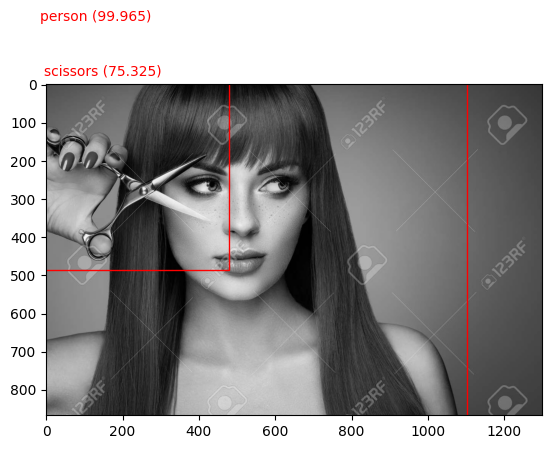

In [21]:
#photo_filename = root + 'giraffa.jpg'
photo_filename = 'dt.jpg'

class_threshold = 0.6
nms_thresh = 0.45

# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (net_w, net_w))

# make prediction 
yolos = yolov3.predict(image) #3 beacuse I have 3 outputs
print([a.shape for a in yolos]) # summarize the shape of the 3 output activation maps

# exclude boxes with class probability < threshold
boxes = list()
for i in range(len(yolos)): #for each yolo output ...
    # decode the output of the network
    boxes += decode_netout(yolos[i][0], anchors[i], class_threshold, net_h, net_w)

# correct the sizes of the bounding boxes to match the original image dimension
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

# choose best boxes according to non-maximum suppresion
do_nms(boxes, nms_thresh)

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [22]:
!pip install pytictoc
from pytictoc import TicToc
t = TicToc()
tt = []
#photo_filename = root + 'giraffa.jpg'
photo_filename = 'dt.jpg'

class_threshold = 0.6
nms_thresh = 0.45

# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (net_w, net_w))

# make prediction
for i in range(3):
  t.tic()
  yolos = yolov3.predict(image) #3 because I have 3 outputs
  t.toc()



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
1/1 [==============================] - 0s 25ms/step
Elapsed time is 0.103963 seconds.
1/1 [==============================] - 0s 25ms/step
Elapsed time is 0.105544 seconds.
1/1 [==============================] - 0s 30ms/step
Elapsed time is 0.108046 seconds.
